# Dynamic k-NN using TensorFlow with GPU Support

From: [artifabrian@github](https://github.com/artifabrian/dynamic-knn-gpu)

This notebook presents a proof-of-concept implementation of a relatively simple Dynamic k-NN using TensorFlow with GPU support.

>In k-NN classification, the output is a class membership. An object is classified by a majority vote of its neighbors, >with the object being assigned to the class most common among its k nearest neighbors (k is a positive integer, >typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor.

from [wikipedia](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)

A dynamic k-NN allows for some parameters (such as the $k$ parameter) to be defined on a per instance basis, instead of being fixed in the model.

This can be useful in cases where the $k$ is influenceed by some independent variable.

Related research:
- [An Improved k-NN Classification with Dynamic k](https://www.researchgate.net/publication/317595386_An_Improved_k-NN_Classification_with_Dynamic_k)

- [Adaptive k-Nearest-Neighbor Classification Using a Dynamic Number of Nearest Neighbors](https://link.springer.com/chapter/10.1007/978-3-540-75185-4_7)

- [Dynamic K-Nearest-Neighbor with Distance and attribute weighted for classification](https://ieeexplore.ieee.org/document/5559858?reload=true)

This notebook is **not** meant to show production ready code and it's mostly just experimental!

Imports:

In [1]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from scipy.stats import skew
from scipy.stats.stats import pearsonr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)
import random
import timeit
import time

matplotlib.rc('font', size=20)
matplotlib.rc('axes', titlesize=20)
matplotlib.rc('axes', labelsize=20)
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('legend', fontsize=20)
matplotlib.rc('figure', titlesize=20)

import tensorflow as tf

Function to plot data (useful for debug):

In [2]:
def plot_data(X, y):
    y = y.flatten()
    
    x_point_class_0 = X[y == 0].T[0].T
    y_point_class_0 = X[y == 0].T[1].T
    
    x_point_class_1 = X[y == 1].T[0].T
    y_point_class_1 = X[y == 1].T[1].T
    
    plt.plot(x_point_class_0, y_point_class_0, 'ro', label='Class 0')
    plt.plot(x_point_class_1, y_point_class_1, 'go', label='Class 1')
    plt.legend()
    plt.show()

In [3]:
def plot_data_with_test_point(X, y, test_point):
    
    y = y.flatten()
    
    x_point_class_0 = X[y == 0].T[0].T
    y_point_class_0 = X[y == 0].T[1].T
    
    x_point_class_1 = X[y == 1].T[0].T
    y_point_class_1 = X[y == 1].T[1].T
    
    x_point_test = test_point.T[0].T
    y_point_test = test_point.T[1].T

    plt.plot(x_point_class_0, y_point_class_0, 'ro', label='Class 0')
    plt.plot(x_point_class_1, y_point_class_1, 'go', label='Class 1')
    plt.plot(x_point_test, y_point_test, 'bo', label='Test Point')
    plt.legend()
    plt.show()

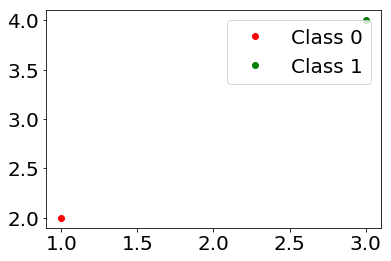

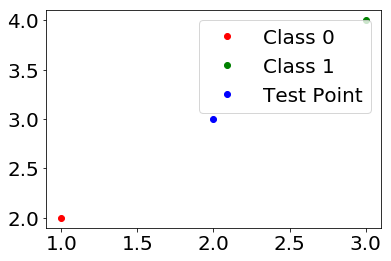

In [4]:
plot_data(np.array([[1,2],[3,4]]), np.array([0, 1]))

plot_data_with_test_point(np.array([[1,2],[3,4]]), np.array([0, 1]), np.array([[2, 3]]))

Random data generator:

In [5]:
def generate_pseudo_random_data(number_of_training_points=350, n_features=2,
                                class_0_mean=150, class_0_std=32,
                                class_1_mean=-15, class_1_std=27):
    
    number_of_training_points_per_class = int(number_of_training_points/2)
    
    X = []
    y = []

    # TODO: make this more efficient.
    for i in range(number_of_training_points_per_class):
        instance_class_zero = []
        
        for j in range(n_features):
            val = np.random.normal(class_0_mean, class_0_std)
            instance_class_zero.append(val)
            
        instance_class_one = []
        for j in range(n_features):
            val = np.random.normal(class_1_mean, class_1_std)
            instance_class_one.append(val)
        
        X.append(instance_class_zero)
        y.append([0]) # Class 0 label.
        
        X.append(instance_class_one)
        y.append([1]) # Class 1 label.
    
    return np.array(X), np.array(y)


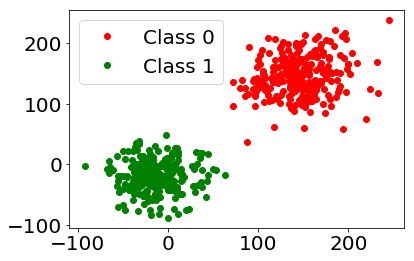

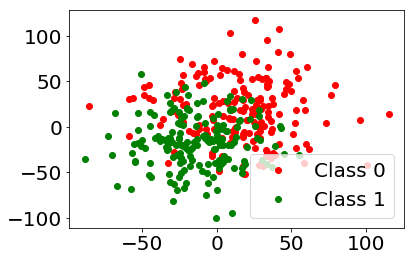

In [6]:
X, y = generate_pseudo_random_data(number_of_training_points=500, n_features=3)

plot_data(X, y)

X, y = generate_pseudo_random_data(class_0_mean=15, class_0_std=32)

plot_data(X, y)

## Building the Model

Creating the model graph for a simple k-nn. The number of k is a placeholder and is expected to vary according to some instance attribute.

For simplicity, it expects only a single GPU.

Testing support for GPU:

In [7]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Example metrics, eventually, more complex metrics could be implemented, such as a weighted distance:

In [8]:
def fast_distance(a, b):
    return tf.reduce_sum(tf.abs(tf.subtract(a, b)), axis=1)

def euclidean_distance(a, b):
    return tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(a, b)), axis=1))

The actual graph model:

In [41]:
def build_knn_graph(number_of_training_points, number_of_features, 
                    distance_metric=euclidean_distance,
                    gpu_enable=False, include_prints=False):
    
    device = '/cpu:0'
    if gpu_enable:
        device = '/gpu:0'
        
    with tf.device(device):
        
        X_train = tf.placeholder(tf.float32, shape=[number_of_training_points, number_of_features],
                                 name="X_train_placeholder")

        y_true = tf.placeholder(tf.float32, shape=[number_of_training_points, 1],
                                name="y_true_placeholder")

        # Expects a single instance.
        X_test = tf.placeholder(tf.float32, shape=[number_of_features], name="X_test_placeholder")
    
        # k is a scalar placeholder
        k = tf.placeholder(tf.int32, shape=(), name="k")
        
        # Calculates the distance from the test instance against the training data.
        distances = distance_metric(X_train, X_test)

        # Negating the distances.
        # (We need this trick because TensorFlow has top_k API and no closest_k or reverse=True api.)
        neg_distances = tf.negative(distances)

        # It returns the 'k' values and indexes from the least distant nodes.
        values, indexes = tf.nn.top_k(neg_distances, k)

        if not gpu_enable and include_prints:
            indexes = tf.Print(indexes, [values, indexes], message="Top k Results:")

        # We gather the classes using the indexes in the y_true tensor.
        # (It works as an efficient "multiple get".)
        y_neighbours = tf.gather(y_true, indexes)
        
        # Since the class is discrete we cast it into an int32.
        y_neighbours = tf.cast(y_neighbours, tf.int32)

        # We aggregate sums of the values and calculate how many values from each class is there on the neighbourhood.
        # (i.e. creates a tensor with the count on each index for each class)
        y_counts = tf.bincount(y_neighbours)

        if not gpu_enable and include_prints:
            y_counts = tf.Print(y_counts, [y_counts, y_neighbours], message="Counts:")
        
        # Gets the index (i.e. corresponding class) with the max count.
        # (Unfortunately this operation doesn't seem to work on GPU as of TensorFlow 1.11.0
        #  An alternative to this is to use "allow_soft_placement=True")
        with tf.device('/cpu:0'):
            class_pred = tf.argmax(y_counts)

    return class_pred, y_counts, X_train, y_true, X_test, k


A simple test for the model:

Predicted class for test point 1: 0
Predicted class for test point 2: 1


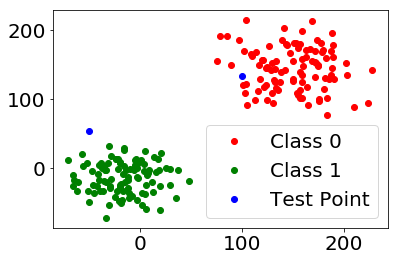

In [42]:
# Generate some data.
X, y = generate_pseudo_random_data(number_of_training_points=200, n_features=2)

# Build the graph.
class_pred, counts, X_train, y_true, X_test, k = build_knn_graph(X.shape[0], X.shape[1], gpu_enable=True)

# Example test point
test_point_1 = [100.0, 134.0]
test_point_2 = [-50.0, 54.0]

# Run a session.
# (log_device_placement=True => verbose output of where each operation is mapped)
# (gpu_options.allow_growth = True => attempts to allocate only as much GPU memory based on runtime allocations)
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True

session = tf.Session(config=config)
session.run(tf.global_variables_initializer())

test_point_1_pred = session.run(class_pred, feed_dict={X_train: X, y_true: y, X_test: test_point_1, k: 15})
test_point_2_pred = session.run(class_pred, feed_dict={X_train: X, y_true: y, X_test: test_point_2, k: 15})

session.close()

# Show results!
print("Predicted class for test point 1: %s" % test_point_1_pred)
print("Predicted class for test point 2: %s" % test_point_2_pred)
plot_data_with_test_point(X, y, np.array([test_point_1, test_point_2]))

## A simple benchmark

A simple performance benchmark to check the results of CPU vs GPU and how it compares against a popular implementation.

### Data Generation

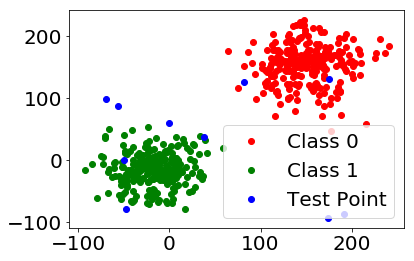

k neighbours for each instance: [1337, 9612, 9402, 2663, 3990, 3797, 842, 9797, 6527, 8935]


In [51]:
# Data params
number_of_training_points = 200000
n_features = 1000
n_test_points = 10

# Example test point
test_points = []
for i in range(n_test_points):
    test_points.append(random.choices(list(range(-100, 200)), k=n_features))

# Dynamic k
k_values = random.choices(list(range(10000)), k=n_test_points)

X, y = generate_pseudo_random_data(number_of_training_points=number_of_training_points, n_features=n_features)

plot_data_with_test_point(X[:500], y[:500], np.array(test_points))

print("k neighbours for each instance: %s" % k_values)

### GPU vs CPU on TensorFlow implementation

In [ ]:
config = tf.ConfigProto()

def test_tf(gpu_enable=True, print_results=True):
    
    start = time.time()
    
    # Run a session.
    session = tf.Session(config=config)
    session.run(tf.global_variables_initializer())
        
    # Build the graph.
    class_pred, counts, X_train, y_true, X_test, k = build_knn_graph(X.shape[0], X.shape[1], gpu_enable=gpu_enable)
        
    for data_point in zip(test_points, k_values):
        
        start_run = time.time()
        test_point_pred = session.run(class_pred, feed_dict={X_train: X, y_true: y, X_test: data_point[0], k: data_point[1]})
        end_run = time.time()
        
        # Show results!
        if print_results:
            print("Predicted class for test point %s(...) using k=%s: %s" %
                    (data_point[0][:10], data_point[1], test_point_pred))
            
            print("Run Time elapsed: %f" % (end_run-start_run))
                

    session.close()
    
    end = time.time()
    print("Time elapsed: %f" % (end-start))
            

            
test_tf(gpu_enable=True, print_results=True)

Actual benchmark:

In [54]:
def test_tf_gpu():
     test_tf(gpu_enable=True, print_results=False)
        
def test_tf_cpu():
     test_tf(gpu_enable=False, print_results=False) 
    

print('Time (s) to knn!.')
print('TF CPU (s):')
tf_time_cpu = timeit.timeit('test_tf_cpu()', number=5, setup="from __main__ import test_tf_cpu")
print(tf_time_cpu)
print('TF GPU (s):')
tf_time_gpu = timeit.timeit('test_tf_gpu()', number=5, setup="from __main__ import test_tf_gpu")
print(tf_time_gpu)
print('TF GPU speedup over TF CPU: {}x'.format(tf_time_cpu/tf_time_gpu))

Time (s) to knn!.
TF CPU (s):
Time elapsed: 11.361576
Time elapsed: 10.950760
Time elapsed: 11.234590
Time elapsed: 11.650291
Time elapsed: 11.681021
56.87980821571364
TF GPU (s):
Time elapsed: 7.988203
Time elapsed: 7.950315
Time elapsed: 7.908797
Time elapsed: 7.887465
Time elapsed: 7.886387
39.62223150841419
TF GPU speedup over TF CPU: 1.4355528714639565x


**Expected Output:**
   
   <html>
<table style="width:30%">
   <tr>
    <th>TF GPU speedup over TF CPU:</th>
  </tr>
  <tr>
    <th>Somewhere between ~1.2-1.4</th>
  </tr>
</table> 
</html>

On large datasets, the GPU gains are more noticeable, however, even on this machine specs, with a low powered GPU, the GPU performance gain is around 40%.

Now let's compare against a popular and well-optimized implementation.

### TensorFlow GPU vs Scikit-Learn Implementation

We are going to use a robust algorithm from a popular library, the [KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) from Scikit-Learn.

A dynamic $k$ value in these algorithms will kill the model performance because their implementation relies on fitting the input according to some well optimized structure beforehand. Since we are dealing with a $k$ (that can range somewhere between 0-10000), we will need to fit the dataset for *each* instance we're trying to predict.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def test_scikit(print_results=True):
    
    start = time.time()
    
    for data_point in zip(test_points, k_values):
        
        start_run = time.time()
        # We need to call fit() on each test data point because the scenario is of a dynamic k
        neigh = KNeighborsClassifier(n_neighbors=data_point[1])
        neigh.fit(X, y.ravel())
        test_point_pred = neigh.predict([data_point[0]])
        end_run = time.time()
        
        # Show results!
        if print_results:
            print("Predicted class for test point %s(...) using k=%s: %s" %
                    (data_point[0][:10], data_point[1], test_point_pred))
            
            print("Run Time elapsed: %f" % (end_run-start_run))
                

    end = time.time()
    print("Time elapsed: %f" % (end-start))
    
test_scikit(print_results=True)

Actual benchmark:

In [59]:
def test_tf_gpu():
     test_tf(gpu_enable=True, print_results=False)
        
def test_scikit_cpu():
     test_scikit(print_results=False)

print('Time (s) to knn!.')
print('Scikit CPU (s):')
scikit_time_cpu = timeit.timeit('test_scikit_cpu()', number=5, setup="from __main__ import test_scikit_cpu")
print(scikit_time_cpu)
print('TF GPU (s):')
tf_time_gpu = timeit.timeit('test_tf_gpu()', number=5, setup="from __main__ import test_tf_gpu")
print(tf_time_gpu)
print('TF GPU speedup over SciKit CPU: {}x'.format(scikit_time_cpu/tf_time_gpu))

Time (s) to knn!.
Scikit CPU (s):
Time elapsed: 754.340670
Time elapsed: 661.100592
Time elapsed: 374.606529
Time elapsed: 368.232012
Time elapsed: 393.661025
2552.01862345655
TF GPU (s):
Time elapsed: 8.357933
Time elapsed: 8.239305
Time elapsed: 8.275646
Time elapsed: 8.252841
Time elapsed: 8.236926
41.36518448057541
TF GPU speedup over TF CPU: 61.69484448098974x


**Expected Output:**
   
   <html>
<table style="width:30%">
   <tr>
    <th>TF GPU speedup over Scikit CPU:</th>
  </tr>
  <tr>
    <th>Somewhere between ~40-60</th>
  </tr>
</table> 
</html>


As seen above, the results are quite favorable towards the k-NN implementation using TensorFlow with GPU support.

This makes it a great solution if we are dealing with any problem where a dynamic $k$ value is needed.

But what about when the $k$ is static?

#### Benchmarking with a static $k$

In [ ]:
def test_scikit_static_k(print_results=True):
    
    start = time.time()
    
    # For this test we will be using a fixed k
    neigh = KNeighborsClassifier(n_neighbors=1000)
    neigh.fit(X, y.ravel())
    
    for i in range(100):
        for data_point in zip(test_points, k_values):

            start_run = time.time()
            test_point_pred = neigh.predict([data_point[0]])
            end_run = time.time()

            # Show results!
            if print_results:
                print("Predicted class for test point %s(...) using k=%s: %s" %
                        (data_point[0][:10], 1000, test_point_pred))

                print("Run Time elapsed: %f" % (end_run-start_run))
                

    session.close()
    
    end = time.time()
    print("Time elapsed: %f" % (end-start))
    
def test_tf_static(gpu_enable=True, print_results=True):
    
    start = time.time()
    
    # Run a session.
    session = tf.Session(config=config)
    session.run(tf.global_variables_initializer())
        
    # Build the graph.
    class_pred, counts, X_train, y_true, X_test, k = build_knn_graph(X.shape[0], X.shape[1], gpu_enable=gpu_enable)
    
    for i in range(100):
        for data_point in zip(test_points, k_values):

            start_run = time.time()
            # For this test we will be using a fixed k=1000
            test_point_pred = session.run(class_pred, feed_dict={X_train: X, y_true: y, X_test: data_point[0], k: 1000})
            end_run = time.time()

            # Show results!
            if print_results:
                print("Predicted class for test point %s(...) using k=%s: %s" %
                        (data_point[0][:10], 1000, test_point_pred))

                print("Run Time elapsed: %f" % (end_run-start_run))
                

    session.close()
    
    end = time.time()
    print("Time elapsed: %f" % (end-start))   

print("Scikit with static k") 
test_scikit_static_k(print_results=False)
print("TF with static k") 
test_tf_static(gpu_enable=True, print_results=False)

Actual benchmark:

In [65]:
def test_tf_static_gpu():
     test_tf_static(gpu_enable=True, print_results=False)
        
def test_scikit_static_k_cpu():
     test_scikit_static_k(print_results=False)

print('Time (s) to knn, using a static k!.')
print('Scikit CPU (s):')
scikit_time_cpu = timeit.timeit('test_scikit_static_k_cpu()', number=5, setup="from __main__ import test_scikit_static_k_cpu")
print(scikit_time_cpu)
print('TF GPU (s):')
tf_time_gpu = timeit.timeit('test_tf_static_gpu()', number=5, setup="from __main__ import test_tf_static_gpu")
print(tf_time_gpu)
print('TF GPU speedup over Scikit CPU: {}x'.format(scikit_time_cpu/tf_time_gpu))

Time (s) to knn!.
Scikit CPU (s):
Time elapsed: 497.392565
Time elapsed: 522.821572
Time elapsed: 777.285934
Time elapsed: 700.358408
Time elapsed: 517.230621
3015.183898477495
TF GPU (s):
Time elapsed: 771.146711
Time elapsed: 853.711834
Time elapsed: 777.135780
Time elapsed: 693.493504
Time elapsed: 668.953792
3764.444491241964
TF GPU speedup over TF CPU: 0.8009638355652116x


**Expected Output:**
   
   <html>
<table style="width:30%">
   <tr>
    <th>TF GPU speedup over Scikit CPU:</th>
  </tr>
  <tr>
    <th>Somewhere between ~0.7-0.8</th>
  </tr>
</table> 
</html>

In this scenario, this implementation of k-NN using TensorFlow with GPU support is actually around 20-30% slower than the Scikit implementation!

However, this is also the worst scenario for this implementation and with a better GPU this difference might decrease. 

In any case, it's impressive that we can obtain such results for such a naíve/simple implementation and there's a lot of room for improvement!